# Document Viewer
This notebook reads documents from the `documents` subfolder and displays them one at a time.

In [ ]:
import os
import sys
from pathlib import Path
from IPython.display import display, Image, Markdown, HTML
import warnings
warnings.filterwarnings('ignore')

# Check if running on Linux (GCP) or Windows
IS_LINUX = sys.platform.startswith('linux')

# Install dependencies if needed
if not IS_LINUX:
    # docx2pdf only works on Windows/Mac with Microsoft Word
    try:
        from docx2pdf import convert
        DOCX2PDF_AVAILABLE = True
    except ImportError:
        import subprocess
        subprocess.check_call(['pip', 'install', 'docx2pdf', '-q'])
        DOCX2PDF_AVAILABLE = True
else:
    # On Linux, use python-docx to read and LibreOffice for conversion
    DOCX2PDF_AVAILABLE = False
    try:
        from docx import Document as DocxDocument
    except ImportError:
        import subprocess
        subprocess.check_call(['pip', 'install', 'python-docx', '-q'])
        from docx import Document as DocxDocument

try:
    import fitz  # PyMuPDF
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'pymupdf', '-q'])
    import fitz

print(f"Platform: {'Linux (GCP)' if IS_LINUX else 'Windows/Mac'}")
print(f"DOCX conversion: {'docx2pdf' if DOCX2PDF_AVAILABLE else 'python-docx (text only)'}")

In [29]:
# Configuration
DOCUMENTS_FOLDER = Path("documents")

# Supported file extensions
WORD_EXTENSIONS = {".docx", ".doc"}
IMAGE_EXTENSIONS = {".png", ".jpg", ".jpeg", ".gif", ".bmp", ".webp"}
TEXT_EXTENSIONS = {".txt", ".md", ".csv", ".json", ".xml", ".html"}
PDF_EXTENSIONS = {".pdf"}

In [ ]:
def get_document_list():
    """Get list of all documents in the documents folder."""
    if not DOCUMENTS_FOLDER.exists():
        print(f"Creating '{DOCUMENTS_FOLDER}' folder...")
        DOCUMENTS_FOLDER.mkdir(parents=True, exist_ok=True)
        return []
    
    documents = sorted([f for f in DOCUMENTS_FOLDER.iterdir() if f.is_file()])
    return documents

def display_word_document_windows(file_path):
    """Display Word document by converting to PDF then rendering as images (Windows/Mac)."""
    import tempfile
    from docx2pdf import convert
    
    # Convert docx to PDF in temp directory
    with tempfile.TemporaryDirectory() as tmp_dir:
        pdf_path = Path(tmp_dir) / (file_path.stem + ".pdf")
        convert(str(file_path), str(pdf_path))
        
        # Open PDF and render each page as image
        pdf_doc = fitz.open(str(pdf_path))
        for page_num in range(len(pdf_doc)):
            page = pdf_doc[page_num]
            mat = fitz.Matrix(2, 2)
            pix = page.get_pixmap(matrix=mat)
            img_data = pix.tobytes("png")
            
            if len(pdf_doc) > 1:
                print(f"Page {page_num + 1} of {len(pdf_doc)}")
            display(Image(data=img_data))
        pdf_doc.close()

def display_word_document_linux(file_path):
    """Display Word document content on Linux (text extraction)."""
    from docx import Document as DocxDocument
    import subprocess
    import tempfile
    
    # Try LibreOffice conversion first (if installed)
    try:
        with tempfile.TemporaryDirectory() as tmp_dir:
            # Convert DOCX to PDF using LibreOffice
            result = subprocess.run(
                ['libreoffice', '--headless', '--convert-to', 'pdf', '--outdir', tmp_dir, str(file_path)],
                capture_output=True, timeout=60
            )
            
            if result.returncode == 0:
                pdf_path = Path(tmp_dir) / (file_path.stem + ".pdf")
                if pdf_path.exists():
                    # Render PDF as images
                    pdf_doc = fitz.open(str(pdf_path))
                    for page_num in range(len(pdf_doc)):
                        page = pdf_doc[page_num]
                        mat = fitz.Matrix(2, 2)
                        pix = page.get_pixmap(matrix=mat)
                        img_data = pix.tobytes("png")
                        if len(pdf_doc) > 1:
                            print(f"Page {page_num + 1} of {len(pdf_doc)}")
                        display(Image(data=img_data))
                    pdf_doc.close()
                    return
    except (subprocess.TimeoutExpired, FileNotFoundError):
        pass
    
    # Fallback: Extract text content using python-docx
    print("(LibreOffice not available - showing text content only)")
    print("-" * 40)
    doc = DocxDocument(str(file_path))
    for para in doc.paragraphs:
        if para.text.strip():
            print(para.text)

def display_document(file_path):
    """Display a document based on its file type."""
    ext = file_path.suffix.lower()
    
    print(f"\n{'='*60}")
    print(f"File: {file_path.name}")
    print(f"{'='*60}\n")
    
    if ext in WORD_EXTENSIONS:
        if DOCX2PDF_AVAILABLE:
            display_word_document_windows(file_path)
        else:
            display_word_document_linux(file_path)
    
    elif ext in IMAGE_EXTENSIONS:
        display(Image(filename=str(file_path)))
    
    elif ext in TEXT_EXTENSIONS:
        with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
            content = f.read()
        if ext == ".md":
            display(Markdown(content))
        elif ext == ".html":
            display(HTML(content))
        else:
            print(content)
    
    elif ext in PDF_EXTENSIONS:
        # Render PDF pages as images
        pdf_doc = fitz.open(str(file_path))
        for page_num in range(len(pdf_doc)):
            page = pdf_doc[page_num]
            mat = fitz.Matrix(2, 2)
            pix = page.get_pixmap(matrix=mat)
            img_data = pix.tobytes("png")
            
            if len(pdf_doc) > 1:
                print(f"Page {page_num + 1} of {len(pdf_doc)}")
            display(Image(data=img_data))
        pdf_doc.close()
    
    else:
        print(f"Unsupported file type: {ext}")
        print(f"File path: {file_path}")

Found 2 document(s)


[Document 1 of 2]

File: Demand Letter.docx



  0%|          | 0/1 [00:00<?, ?it/s]

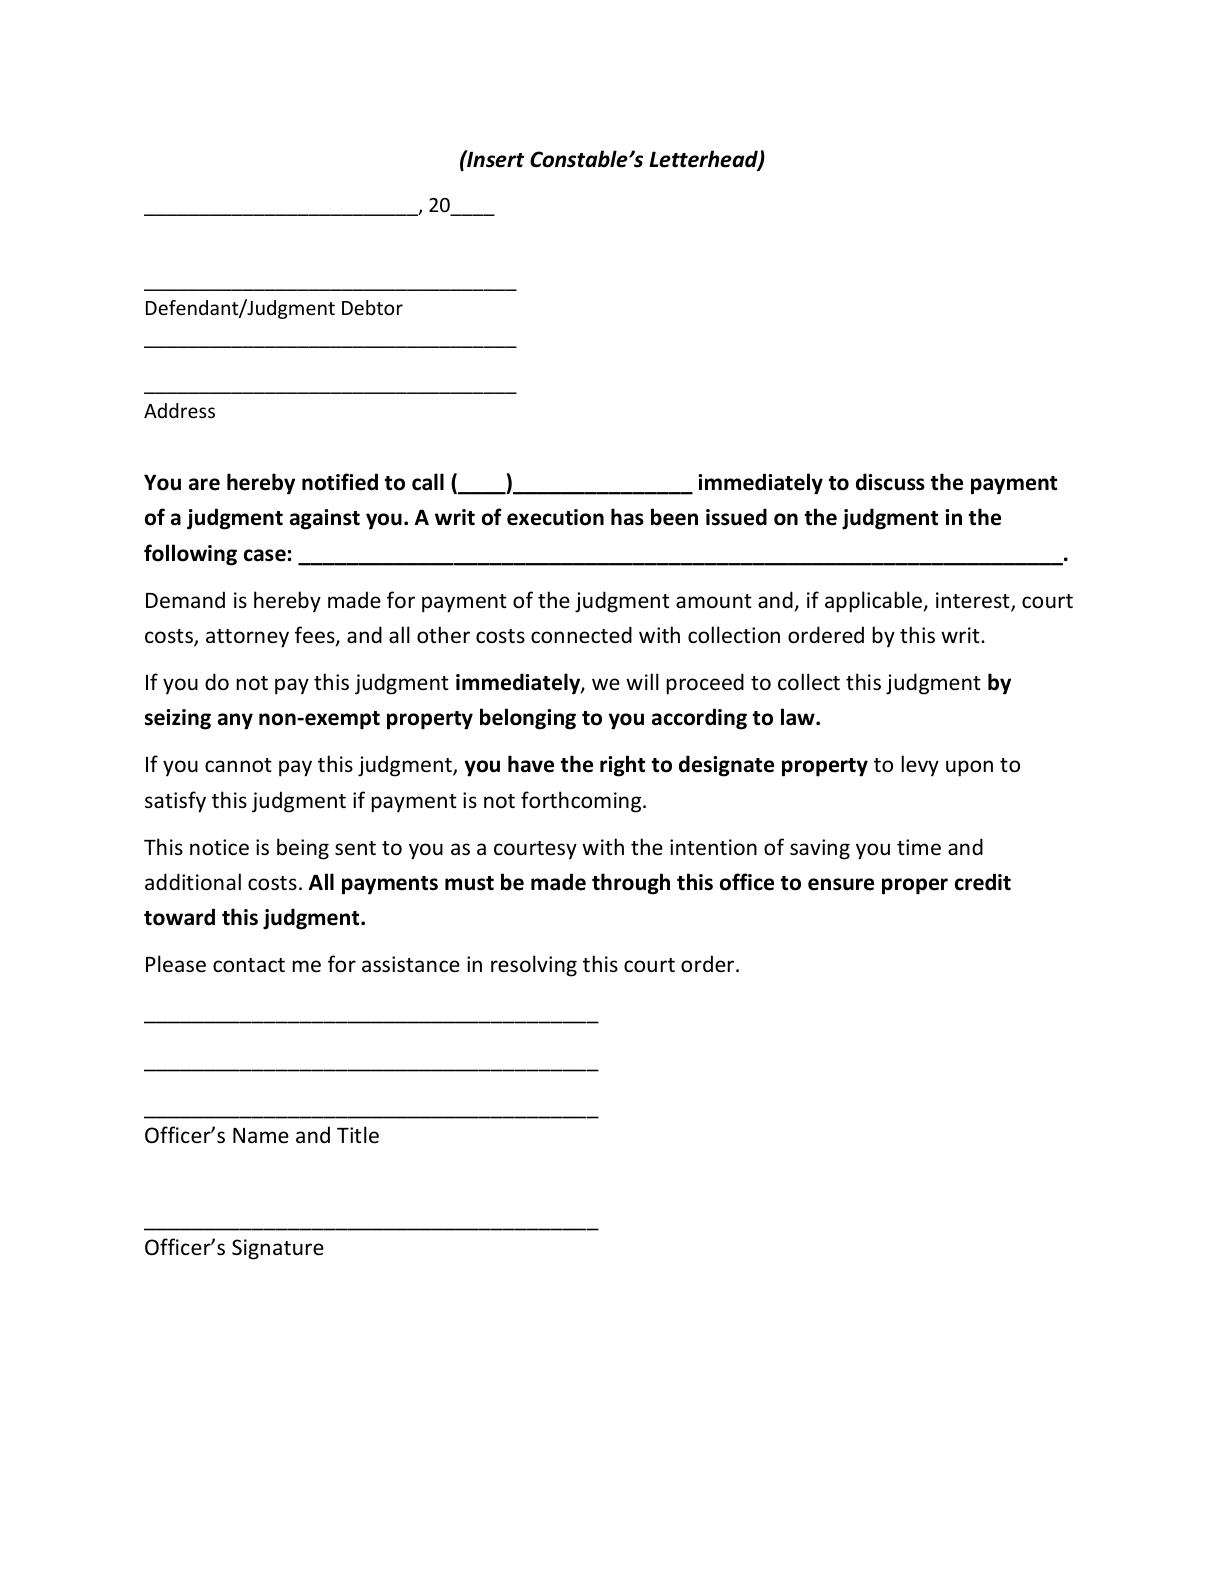


[Document 2 of 2]

File: Notice of Hearing - Public Nuisance.docx



  0%|          | 0/1 [00:00<?, ?it/s]

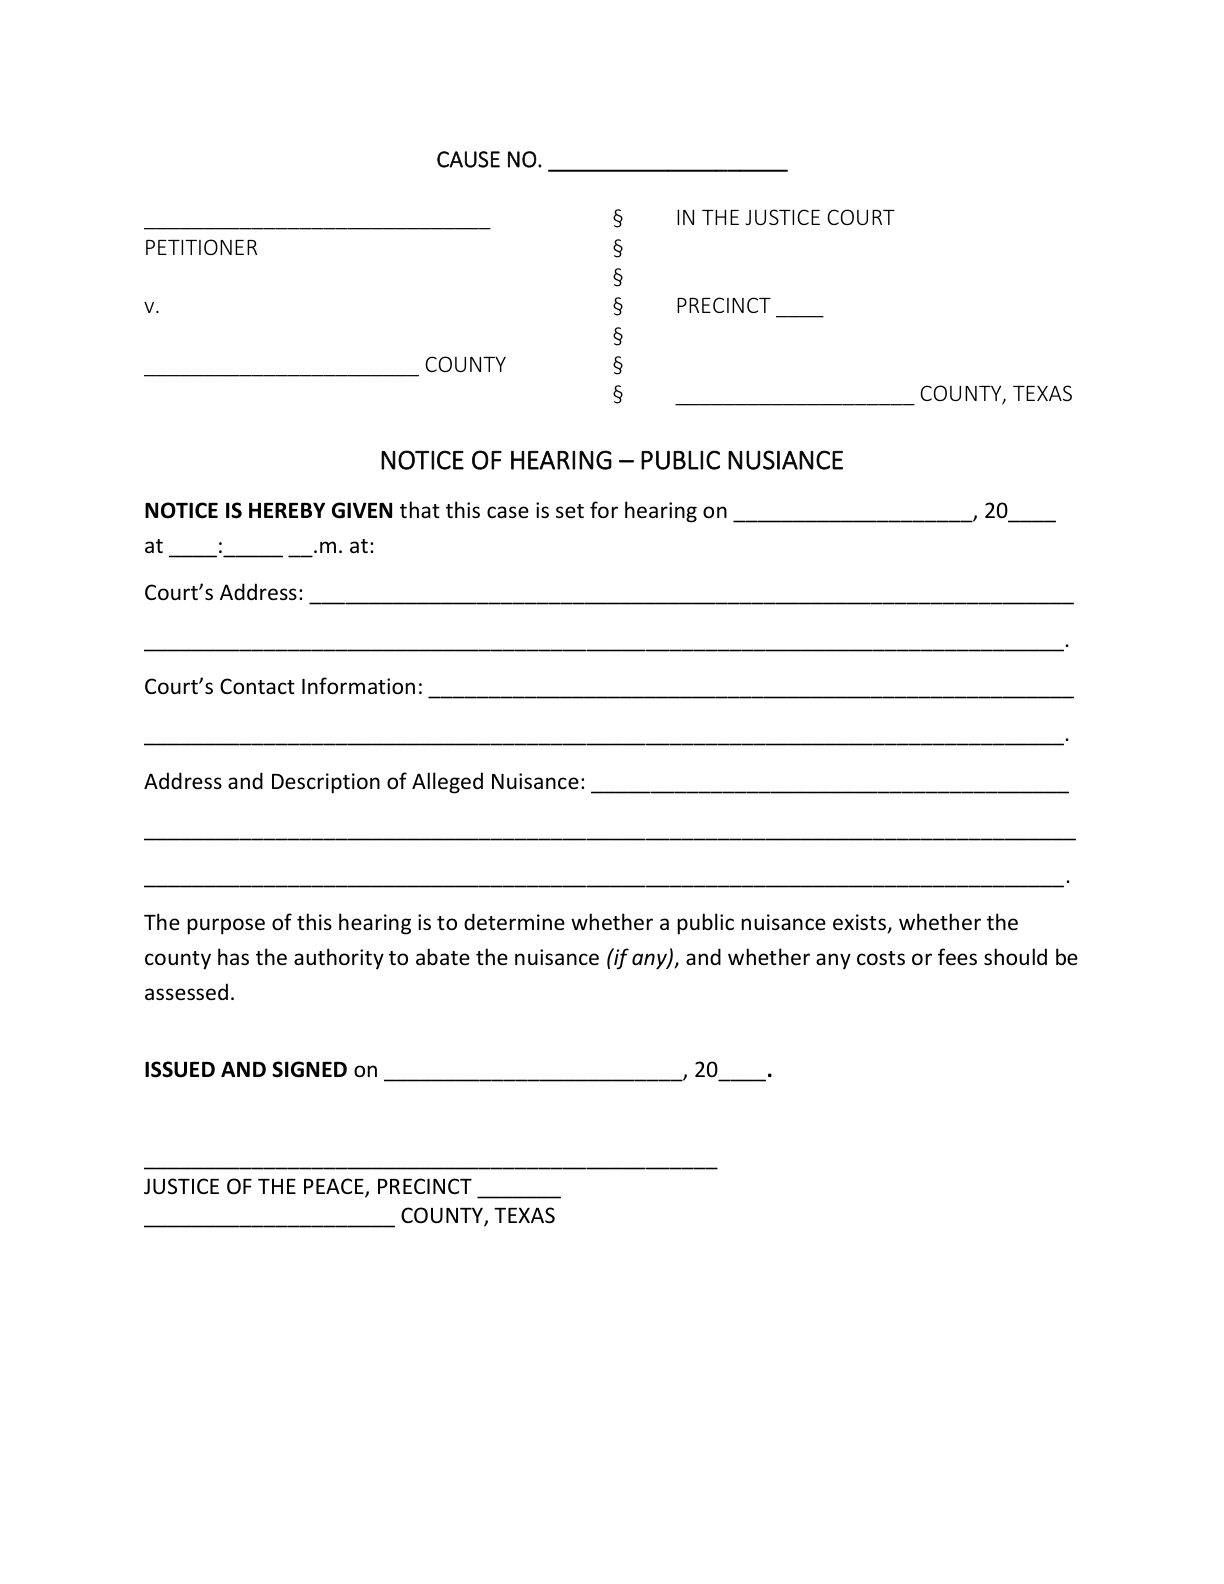

In [31]:
# Display all documents
documents = get_document_list()

if not documents:
    print(f"No documents found in '{DOCUMENTS_FOLDER}' folder.")
    print("Please add documents to the folder and re-run this cell.")
else:
    print(f"Found {len(documents)} document(s)\n")
    for i, doc in enumerate(documents):
        print(f"\n[Document {i + 1} of {len(documents)}]")
        display_document(doc)